Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
img:  <class 'numpy.ndarray'> (213, 320, 3)


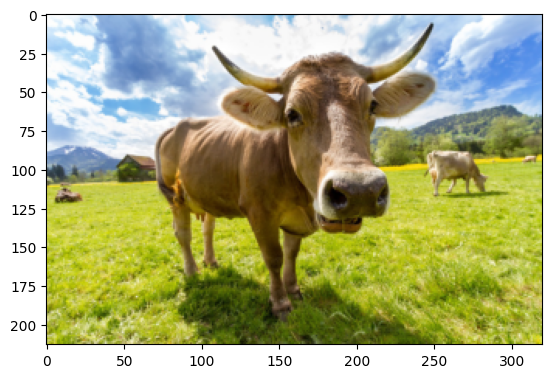

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path # ファイルシステム
from google.colab import drive # Google drive
drive.mount('/content/drive')
p = Path('/content/drive/My Drive/iicex/')  # 画像ファイルのフォルダ
#list( p.iterdir() )  # フォルダの内容をリストにする


from skimage import io #入出力ライブラリ読込
img = io.imread('/content/drive/My Drive/iicex/cow.png')  # 画像ファイルの読み込み
#from PIL import Image #pillow読込
#PILimg = Image.open('/content/drive/My Drive/iicex/baboon.png')  # 画像ファイルの読み込み
#img = PILimg.convert('L') #グレイスケール変換
sampleimg = np.asarray(img) #numpy配列に変換
#print("PILimg: ", type(PILimg))
print("img: ", type(sampleimg), sampleimg.shape)

#plt.imshow(sampleimg, cmap='gray', vmin=0, vmax=255)
plt.imshow(sampleimg)

### cv2を使わないようにしたコード
###（cv2.LUTの代わりとなるDIY_LUTを作った）

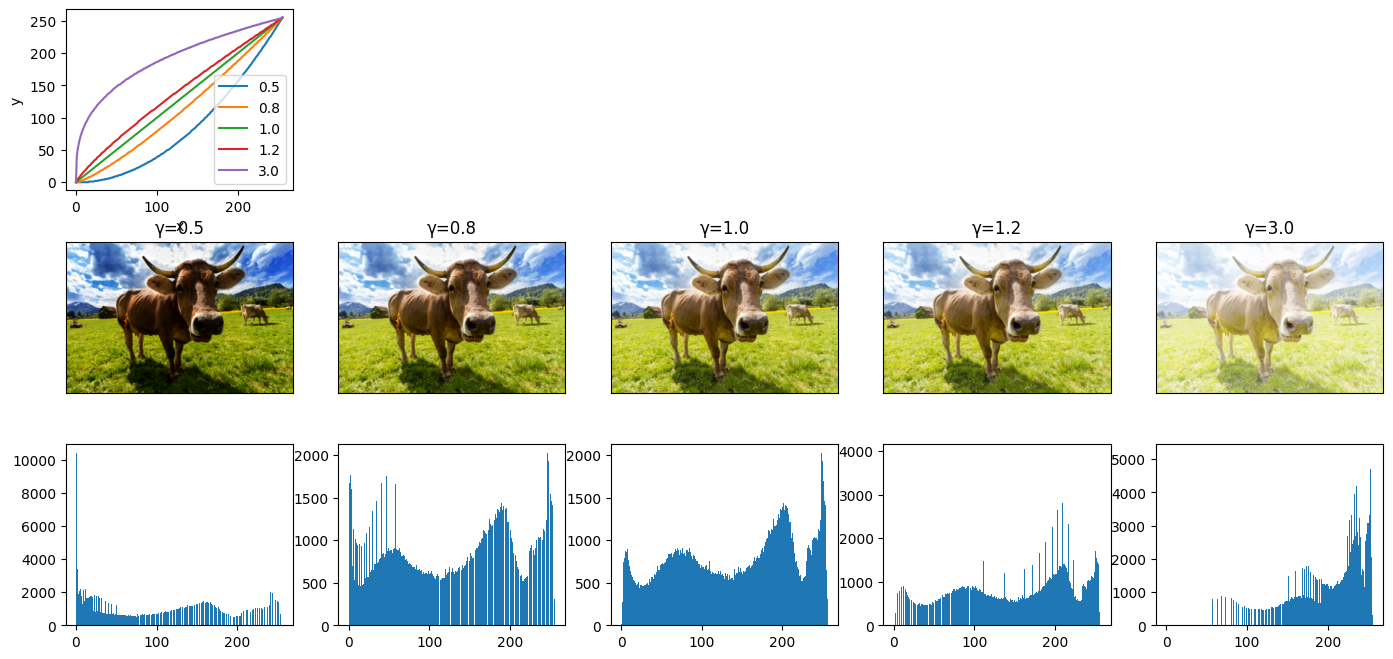

In [3]:
#折れ線型では、トーンカーブの折れ曲がっている点前後で変換の性質が急激に変わるという欠点⇒曲線のカーブ使う
#ガンマ補正のルックアップテーブル(入力画素値と出力画素値の対応表)を作る
def make_gamma_lut(gamma, imax=255):
    x = np.arange(256) #連番・等差数列を生成する関数
    y = imax*(x / imax) ** (1/gamma)

    return y.astype('int')


#LUTの適用_三色用
#np.arrayを引数とする
def DIY_LUT(img, y):
  row = img.shape[0]
  column =  img.shape[1]
  img_LUT = np.zeros((row, column, 3))
  #print(img.shape)
  #print(img_LUT.shape)
  for i in range(row):
    for j in range(column):
      for k in range(3):
        img_LUT[i, j, k] = int(y[int(img[i, j, k])])
  return img_LUT.astype('int')
  #上の行のint関数はなくてもよいが、こっちのnp.array.astype("int")はないとうまくいかない。なぜ？？



# ガンマ補正のトーンカーブの描画
gammas = [0.5, 0.8, 1.0, 1.2, 3.0]

# ガンマ補正のトーンカーブの描画
fig, axes = plt.subplots(3, 5, figsize=(17, 8))
x = np.arange(256) #プロット用
for i in range(len(gammas)):
    y = make_gamma_lut(gammas[i]) #ガンマごとにLUTの作成
    axes[0][0].plot(x, y, label=str(gammas[i])); #トーンカーブ（階調変換関数のグラフ）をプロット#各グラフに名前つけとく
    if i != 0: #使わない領域は消しとこう
      axes[0][i].axis("off")

    img_lut = DIY_LUT(img, y) #opencv使うと画像に直でLUT適用できる
    #print("type(img_lut)", type(img_lut), img_lut.shape, img_lut)
    axes[1][i].imshow(img_lut, 'gray')
    axes[1][i].set_xticks([]) #軸消す
    axes[1][i].set_yticks([]) #軸消す
    axes[1][i].set_title('γ=' + str(gammas[i])) #グラフタイトル

    axes[2][i].hist(img_lut.flatten(),256,[0,256]); #ヒストグラムつくる
    #plt.hist(データ, 階級の数, 使うデータの最小最大値)

axes[0][0].legend(); #凡例
axes[0][0].set_xlabel('x') #plt.figureで宣言した時はfig.xlabel()だが、axを宣言した場合はax.set_xlabel()
axes[0][0].set_ylabel('y')


plt.show()

type <class 'float'>


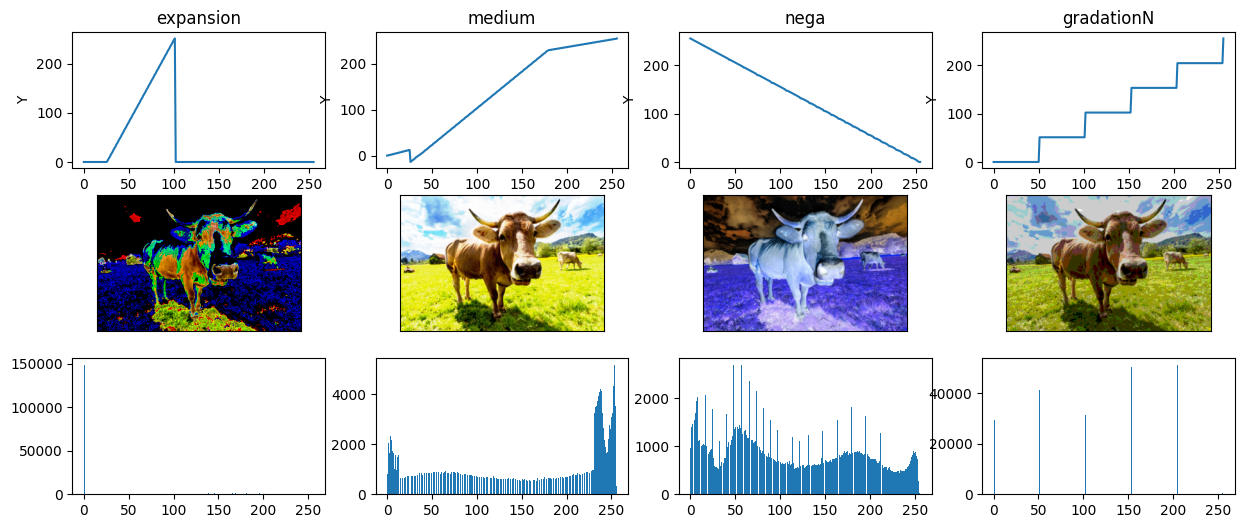

In [4]:
#拡大強調
def expansion(x):
  if (0.1 < x) and (x < 0.4):
    return -1/3 + x * (1.0 / 0.3)
  else:
    return 0

#中間輝度レベル強調
def medium(x):
  if (x < 0.1):
    return 0.5 * x
  elif (x < 0.7):
    return 1.6 * x - 0.22
  else:
    return 0.33 * x + 0.67

#反転
def nega(x):
  return 1 - x

#n値化
def gradationN(x):
  N = 5
  return (float((np.floor(x * 5)) )) / 5


#LUTを作る
def makeLUT(func, imax = 255):
    X = np.arange(256) #連番・等差数列を生成する関数np.arange()
    #正規化して関数に代入して戻す
    Y = np.zeros(256)

    for i in range(256):
      #print(X[i])
      Y[i] = imax * func( ( X[i] / imax))

    return Y.astype('int')


print("type", type(gradationN(4)))



titles = ["expansion", "medium", "nega", "gradationN"]
Ys = [ makeLUT( expansion ), makeLUT( medium ), makeLUT( nega ), makeLUT( gradationN )]
#print(Ys[0])




fig, axes = plt.subplots(3, 4, figsize=(15, 6))
X = np.arange(256) #プロット用
for i in range(4):
    axes[0][i].plot(X, Ys[i]); #トーンカーブ（階調変換関数のグラフ）をプロット#各グラフに名前つけとく
    axes[0][i].set_xlabel('X') #plt.figureで宣言した時はfig.xlabel()だが、axを宣言した場合はax.set_xlabel()
    axes[0][i].set_ylabel('Y')
    axes[0][i].set_title(titles[i]) #グラフタイトル

    img_lut = DIY_LUT(img, Ys[i]) #自作の関数で適用
    #print("type(img_lut)", type(img_lut), img_lut.shape)
    axes[1][i].imshow(img_lut)
    axes[1][i].set_xticks([]) #軸消す
    axes[1][i].set_yticks([]) #軸消す


    axes[2][i].hist(img_lut.flatten(),256,[0,256]); #ヒストグラムつくる
    #plt.hist(データ, 階級の数, 使うデータの最小最大値)



plt.show()


###cv2.lutを使ったコード

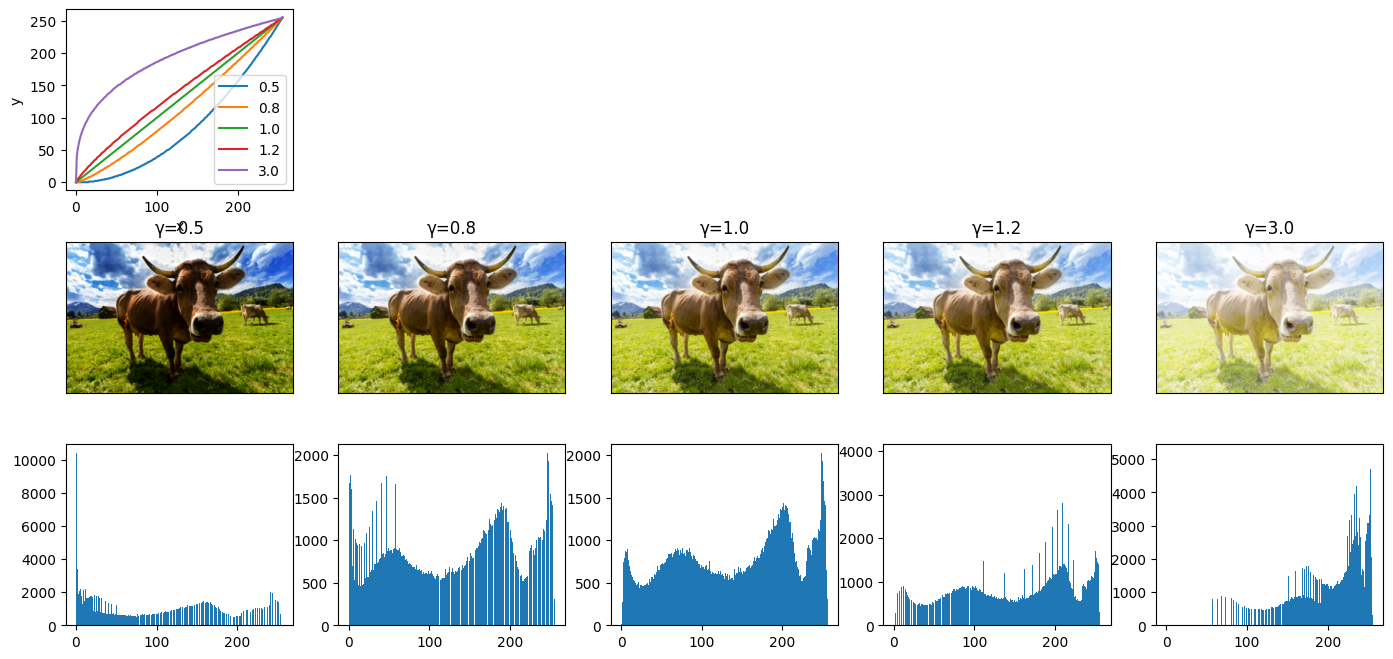

In [ ]:
#折れ線型では、トーンカーブの折れ曲がっている点前後で変換の性質が急激に変わるという欠点⇒曲線のカーブ使う
#ガンマ補正のルックアップテーブル(入力画素値と出力画素値の対応表)を作る
def make_gamma_lut(gamma, imax=255):
    x = np.arange(256) #連番・等差数列を生成する関数
    y = imax*(x / imax) ** (1/gamma)

    return y.astype('int')





# ガンマ補正のトーンカーブの描画
gammas = [0.5, 0.8, 1.0, 1.2, 3.0]

import cv2
fig, axes = plt.subplots(3, 5, figsize=(17, 8))
x = np.arange(256) #プロット用
for i in range(len(gammas)):
    y = make_gamma_lut(gammas[i]) #ガンマごとにLUTの作成
    axes[0][0].plot(x, y, label=str(gammas[i])); #トーンカーブ（階調変換関数のグラフ）をプロット#各グラフに名前つけとく
    if i != 0: #使わない領域は消しとこう
      axes[0][i].axis("off")

    img_lut = cv2.LUT(img, y) #opencv使うと画像に直でLUT適用できる
    #print("type(img_lut)", type(img_lut), img_lut.shape)
    axes[1][i].imshow(img_lut, 'gray')
    axes[1][i].set_xticks([]) #軸消す
    axes[1][i].set_yticks([]) #軸消す
    axes[1][i].set_title('γ=' + str(gammas[i])) #グラフタイトル

    axes[2][i].hist(img_lut.flatten(),256,[0,256]); #ヒストグラムつくる
    #plt.hist(データ, 階級の数, 使うデータの最小最大値)

axes[0][0].legend(); #凡例
axes[0][0].set_xlabel('x') #plt.figureで宣言した時はfig.xlabel()だが、axを宣言した場合はax.set_xlabel()
axes[0][0].set_ylabel('y')


plt.show()

type <class 'float'>


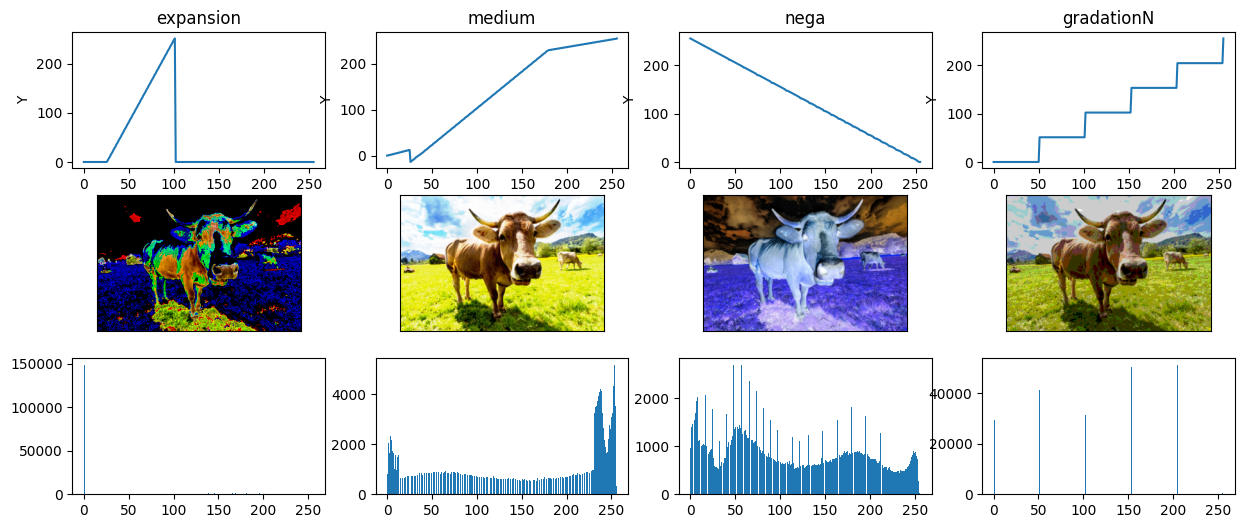

In [ ]:
#拡大強調
def expansion(x):
  if (0.1 < x) and (x < 0.4):
    return -1/3 + x * (1.0 / 0.3)
  else:
    return 0

#中間輝度レベル強調
def medium(x):
  if (x < 0.1):
    return 0.5 * x
  elif (x < 0.7):
    return 1.6 * x - 0.22
  else:
    return 0.33 * x + 0.67

#反転
def nega(x):
  return 1 - x

#n値化
def gradationN(x):
  N = 5
  return (float((np.floor(x * 5)) )) / 5


#LUTを作る
def makeLUT(func, imax = 255):
    X = np.arange(256) #連番・等差数列を生成する関数np.arange()
    #正規化して関数に代入して戻す
    Y = np.zeros(256)

    for i in range(256):
      #print(X[i])
      Y[i] = imax * func( ( X[i] / imax))

    return Y.astype('int')


print("type", type(gradationN(4)))



titles = ["expansion", "medium", "nega", "gradationN"]
Ys = [ makeLUT( expansion ), makeLUT( medium ), makeLUT( nega ), makeLUT( gradationN )]
#print(Ys[0])

fig, axes = plt.subplots(3, 4, figsize=(15, 6))
X = np.arange(256) #プロット用
for i in range(4):
    axes[0][i].plot(X, Ys[i]); #トーンカーブ（階調変換関数のグラフ）をプロット#各グラフに名前つけとく
    axes[0][i].set_xlabel('X') #plt.figureで宣言した時はfig.xlabel()だが、axを宣言した場合はax.set_xlabel()
    axes[0][i].set_ylabel('Y')
    axes[0][i].set_title(titles[i]) #グラフタイトル

    img_lut = cv2.LUT(img, Ys[i]) #opencv使うと画像に直でLUT適用できる
    #print("type(img_lut)", type(img_lut), img_lut.shape, img_lut)
    axes[1][i].imshow(img_lut)
    axes[1][i].set_xticks([]) #軸消す
    axes[1][i].set_yticks([]) #軸消す


    axes[2][i].hist(img_lut.flatten(),256,[0,256]); #ヒストグラムつくる
    #plt.hist(データ, 階級の数, 使うデータの最小最大値)



plt.show()